# Fully Convolutional Neural Networks (FCNNs) - Denoising Example



In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Denoising FCNN

Develop a FCNN model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

- Data download link: https://drive.google.com/file/d/1O811Dsz8e_R2zfXVoeXMG2ZeayBUdoVn/view?usp=sharing


### 2.1 Load data  and split into train, validation, test

In [2]:
# Loading the data
data = np.load("../Data/denoising-1d/noisy_transients.npy")
target = np.load("../Data/denoising-1d/reference.npy")


# Shuffle the samples
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]


# Splitting the data into train/val/test
X_train = data[:int(data.shape[0]*0.8)]
Y_train = target[:int(data.shape[0]*0.8)]

X_val = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test = data[int(data.shape[0]*0.9):]
Y_test = target[int(data.shape[0]*0.9):]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [3]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())

-2.9169581831740183 3.7456143553633217 0.19732772338851437 0.716510288617798


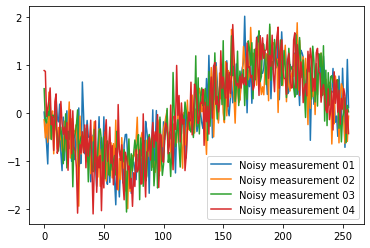

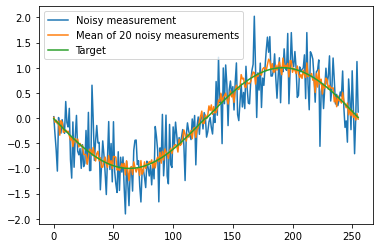

In [4]:
plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement 01")
plt.plot(X_train[0,:,1], label = "Noisy measurement 02")
plt.plot(X_train[0,:,2], label = "Noisy measurement 03")
plt.plot(X_train[0,:,3], label = "Noisy measurement 04")
plt.legend()
plt.show()

plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement")
plt.plot(X_train[0,:,:].mean(axis = -1), label = "Mean of 20 noisy measurements")
plt.plot(Y_train[0,:], label = "Target")
plt.legend()
plt.show()



### 2.3. Data scaling and Data augmentation

In [5]:
mean_train, std_train = X_train.mean(), X_train.std()

Xtrain_norm = (X_train - mean_train)/std_train 
Ytrain_norm = (Y_train - mean_train)/std_train

Xval_norm = (X_val - mean_train)/std_train
Yval_norm = (Y_val - mean_train)/std_train

Xtest_norm = (X_test - mean_train)/std_train
Ytest_norm = (Y_test - mean_train)/std_train

In [6]:
print(Xtrain_norm.min(),Xtrain_norm.max(),Xtrain_norm.mean(),Xtrain_norm.std())

-4.3464636252051925 4.952178200845822 2.384923534379966e-17 0.9999999999999998


### 2.4. Define your  model

In [7]:
# Define your model here. 
def my_fcnn(ishape = (256,20),lr = 1e-3):
    input_layer = tf.keras.layers.Input(shape = ishape)
    conv1 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(input_layer)
    conv2 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv1)
    conv3 = tf.keras.layers.Conv1D(60,3, padding = "same", activation = 'relu')(conv2)
    conv4 = tf.keras.layers.Conv1D(60,3,padding = "same", activation = 'relu')(conv3)
    out = tf.keras.layers.Conv1D(1,1, padding = "same",activation = 'linear')(conv4)
    model = tf.keras.models.Model(inputs = input_layer, outputs = out)
    
    return model

### 2.5. Define your callbacks (save your model, patience, etc.)

In [8]:
model_name = "../Data/best_model_flat_cnn.h5"
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%10 == 0 and epoch!=0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

In [ ]:
model = my_fcnn()
print(model.summary())

model.compile(optimizer = tf.keras.optimizers.Adam(), loss = "mse")

### 2.6. Train your model

In [ ]:
# train your model - decide for how many epochs
model.fit(Xtrain_norm,Ytrain_norm,batch_size = 8, epochs = 10, verbose = 1,\
          validation_data = (Xval_norm,Yval_norm), [early_stop, monitor, lr_schedule], shuffle = True )

### 2.7. Test your model

In [ ]:
#model.load_weights(model_name_unet)
Ypred = model.predict(Xtest_norm)[:,:,0]

Ymean = Xtest_norm.mean(axis = -1)

In [ ]:


# Remember to "unscale your data".


print("FCNN MSE:")
print(((Ypred - Ytest_norm)**2).mean())
print("Mean MSE:")
print(((Ymean - Ytest_norm)**2).mean())

#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean[ii], label = "Mean")
    plt.plot(Ypred[ii], label = "UNET")
    plt.plot(Y_test2[ii], label = "Target")
    plt.legend()
plt.show()